In [460]:
import pandas as pd
import numpy as np

from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt

# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz


### Functions

In [461]:
# General mathematical Functions
def percent(val, total):
    return round(100 * val/total, 2)
    
# General Dataframe functions
def listColumsWithMissingData(df):
    naCols = len(df.columns[df.isna().any()])
    print(f"Columns with missing data: {naCols} {percent(naCols, len(df.columns))}%")
    [print(f"{col:30}  {df[col].isna().sum(): 7d} {percent(df[col].isna().sum(),df.shape[0])}%") for col in df.columns if df[col].isna().any() ]

def getGeneralInfo(df):
    print(df.info());print()
    getCategoricalValues(df);print()
    listColumsWithMissingData(df);print()

def getCategoryDf(df, category):
    return df[category + ['SK_ID_CURR', 'TARGET']]

def getBasicDf(df):
    return df[list(set(df.columns.tolist() ) - set(['SK_ID_CURR', 'TARGET']))]
    
def getColumnsStartingWith(df, prefix):
    prefixlen = len(prefix)
    return list(filter(lambda x: x[:prefixlen] == prefix, df.columns.tolist()))

def getCategoricalValues(df):
    cat_columns = df.select_dtypes(include=['object']).columns.tolist()
    cat_columns.sort()
    print(f"Columns with categorical values {len(cat_columns)} --> {cat_columns}")
    for col in cat_columns:
        count_values = df[col].unique().shape[0]
        print(f"{col:27} : [{count_values:2}]", end=' ')
        if count_values < 10:
            print(f"--> {sorted((df[col].unique().tolist())) if np.NaN not in df[col].unique().tolist() else (df[col].unique().tolist())}", end=' ')
        print()
       

In [462]:
def ConvertClassToNumLabel(df, col):
    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(df[col].unique().tolist())
    class_to_label = dict(zip(le.classes_, labels))
    print(class_to_label)
    return df[col].map(class_to_label) 

In [ ]:
def groupByAndCount(df, col, sort = True, skipPercent=True):
    total_rows = df.shape[0]
    df_ = df.groupby(by=col).agg({col:"count"})
    df_.rename(columns={col:'Count'}, inplace=True)
    df_.reset_index(inplace=True)
    if sort == True: df_.sort_values(by='Count', ascending=False, inplace=True)
    if not skipPercent:
        df_['%'] = round((df_['Count']/total_rows)*100,2)
    return df_

def groupPerTarget(df, col):
    df_1 = df[df['Exited']==1][[col,'Exited']]
    cnt_1 = df_1.shape[0]
    df_1 = groupByAndCount(df_1, col, sort = False)
    df_1.rename(columns={'Count':'Exited=1'},inplace=True)

    df_0 = df[df['Exited']==0][[ col,'Exited']]
    cnt_0 = df_0.shape[0]
    df_0 = groupByAndCount(df_0, col, sort = False)
    df_0.rename(columns={'Count':'Exited=0'},inplace=True)

    df_ = df_0.merge(df_1, how='left',on=col)
    if df_.isna().sum().sum() > 0:
        df_.fillna(0, inplace=True)
    df_['Total'] = df_['Exited=0'] + df_['Exited=1']
    df_['Exited=0%'] = percent(df_['Exited=0'], df_['Total']) 
    df_['Exited=1%'] = percent(df_['Exited=1'], df_['Total'])
    df_.set_index(col, inplace=True)

    df_= df_[['Total', 'Exited=1', 'Exited=0', 'Exited=1%', 'Exited=0%' ]]

    print(f"df_1: {cnt_1}, df_0: {cnt_0}")
    print(df_)
    
    return df_

def plotTargetWiseBarPlots(df, col, title, labels=[], figsize=(15, 6)):
    df_ = groupPerTarget(df, col)
    ax = df_[['Exited=0%','Exited=1%']].plot.bar(ax=plt.gca(), logy=True, figsize=figsize); annotate(ax)
    if labels: ax.set_xticklabels(labels=labels, rotation=45)
    ax.set_title(f"{title} Vs Exited - %age values")
    #plt.show()

In [463]:
def plotBar(df, title, w=10, h=10, logy=False):
    plt.figure(figsize=(w, h), dpi=80)
    ax = df.plot.bar(logy=logy) 
    # Annotate
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.set_title(title)
    plt.show()

'''def annotate(ax):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')'''

def annotate(ax, title='', strformat='', divideby=1):
    # Annotate
    for p in ax.patches:
        # format(, '.1f')
        value = p.get_height()/divideby
        ax.annotate(f"{value:.1f}{strformat}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    ax.set_title(title)

def plotScatter(df, col1, col2, title, pos=1, log=False):
    plt.subplot(1, 2, pos)
    ax = df.plot.scatter(col1, col2,figsize=(10, 6))
    if log == True: ax.set_xscale('log')
    ax.set_title(title)
    plt.show()

# TODO: annotation - add %
def plotTargetWiseBarPlots(df, col, title, labels=[], figsize=(10, 6)):
    df_ = groupPerTarget(df, col)

    plt.figure(dpi=80) #figsize=(20, 6),dpi=80
    plt.subplot(1, 2, 1)

    ax = df_[['Exited=0','Exited=1']].plot.bar(ax=plt.gca(), logy=True, figsize=figsize, rot=90)
    annotate(ax)
    if labels: ax.set_xticklabels(labels=labels, rotation=45)
    ax.set_title(f"{title} Vs Exited - Absolute values")

    plt.subplot(1, 2, 2)
    ax = df_[['Exited=0%','Exited=1%']].plot.bar(ax=plt.gca(), logy=True, figsize=figsize)
    annotate(ax)
    if labels: ax.set_xticklabels(labels=labels, rotation=45)
    ax.set_title(f"{title} Vs Exited - %age values")

    plt.show()

In [494]:
from graphviz import Source
def get_dt_graph(dt_classifier, X):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True, feature_names=X.columns, class_names=['Exited', 'Not Exited'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.set_size('"15,25!"')
    return graph.create_png()

def evaluate_model(dt_classifier, category, X, y):
    print(f"{category} Accuracy : {percent(accuracy_score(y, dt_classifier.predict(X)), 1)}%")
    print(f"{category} Confusion Matrix:")
    print(confusion_matrix(y, dt_classifier.predict(X)))

### Read data and perform first checks

In [465]:
df = pd.read_csv("data/Churn_Modelling.csv")
getGeneralInfo(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None

Columns with categorical values 3 --> ['Gender', 'Geography', 'Surname']
Gender         

Notes:
- **Exited** is the target variable. 
    - 1 --> There was a churn. 
    - 0 --> There was no churn. 
- Is the dataset is balanced or imbalanced?
- From the name, features RowNumber, CustomerId seem to have unique values. 
- From the name, features HasCrCard, IsActiveMember seem to be boolean variables.

Let's check

In [466]:
# Check if RowNumber, CustomerId have unique values?
print('RowNumber', df[df['RowNumber'].duplicated()].shape[0])
print('CustomerId', df[df['CustomerId'].duplicated()].shape[0])

RowNumber 0
CustomerId 0


In [467]:
# Check if HasCrCard, IsActiveMember are boolean variables?
print(f"HasCrCard:\n{df['HasCrCard'].value_counts()}"); print()
print(f"IsActiveMember:\n{df['IsActiveMember'].value_counts()}")

HasCrCard:
1    7055
0    2945
Name: HasCrCard, dtype: int64

IsActiveMember:
1    5151
0    4849
Name: IsActiveMember, dtype: int64


0    79.63
1    20.37
Name: Exited, dtype: float64


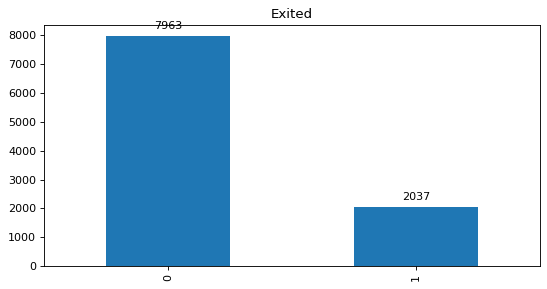

In [468]:
# Is the dataset is balanced or imbalanced wrt the target variable?
print(df['Exited'].value_counts(normalize=True)*100)
plotBar(df['Exited'].value_counts(), 'Exited', w=8, h=4)

**Conclusions**
- Columns RowNumber, CustomerId have unique values (identifiers). So these can be removed.
- Column Surname is only an identifier. So this can also be removed.
- Columns HasCrCard, IsActiveMember are boolean variables.
- None of the columns have missing values. No imputation of missing values is required
- The dataset is imbalanced wrt the target variable. 

In [469]:
df.drop(columns=['RowNumber', 'CustomerId','Surname'], inplace=True)
getGeneralInfo(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB
None

Columns with categorical values 2 --> ['Gender', 'Geography']
Gender                      : [ 2] --> ['Female', 'Male'] 
Geography                   : [ 3] --> ['France', 'Germany', 'Spain'] 

Columns with missing data: 0 0.

Now the identifier columns have been dropped.

In [470]:
print(df[COLS_NUMERIC].describe())

                Age  EstimatedSalary        Balance  NumOfProducts  \
count  10000.000000     10000.000000   10000.000000   10000.000000   
mean      38.921800    100090.239881   76485.889288       1.530200   
std       10.487806     57510.492818   62397.405202       0.581654   
min       18.000000        11.580000       0.000000       1.000000   
25%       32.000000     51002.110000       0.000000       1.000000   
50%       37.000000    100193.915000   97198.540000       1.000000   
75%       44.000000    149388.247500  127644.240000       2.000000   
max       92.000000    199992.480000  250898.090000       4.000000   

             Tenure   CreditScore  
count  10000.000000  10000.000000  
mean       5.012800    650.528800  
std        2.892174     96.653299  
min        0.000000    350.000000  
25%        3.000000    584.000000  
50%        5.000000    652.000000  
75%        7.000000    718.000000  
max       10.000000    850.000000  


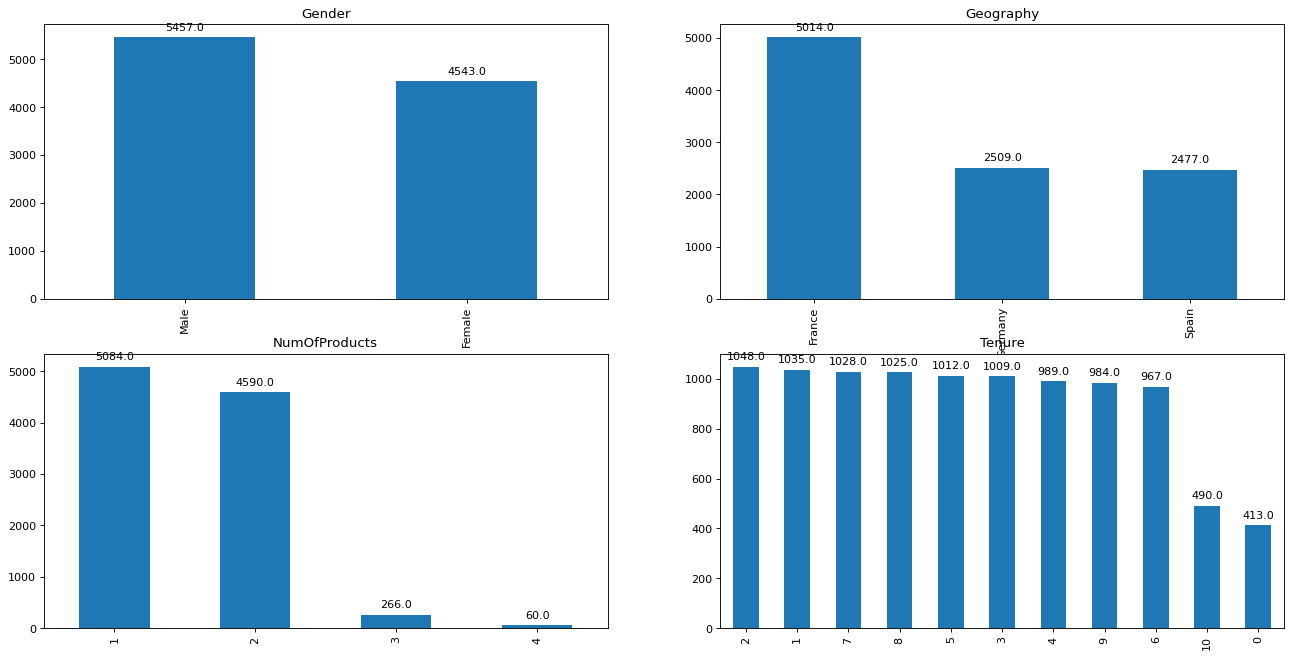

In [471]:
plt.figure(dpi=80, figsize=(20, 10))

plt.subplot(2, 2, 1); ax = df['Gender'].value_counts().plot.bar(); annotate(ax=ax, title='Gender')
plt.subplot(2, 2, 2); ax = df['Geography'].value_counts().plot.bar(); annotate(ax=ax, title='Geography')
plt.subplot(2, 2, 3); ax = df['NumOfProducts'].value_counts().plot.bar(); annotate(ax=ax, title='NumOfProducts')
plt.subplot(2, 2, 4); ax = df['Tenure'].value_counts().plot.bar(); annotate(ax=ax, title='Tenure')

df_1: 2037, df_0: 7963
        Total  Exited=1  Exited=0  Exited=1%  Exited=0%
Gender                                                 
Female   4543      1139      3404      25.07      74.93
Male     5457       898      4559      16.46      83.54
df_1: 2037, df_0: 7963
           Total  Exited=1  Exited=0  Exited=1%  Exited=0%
Geography                                                 
France      5014       810      4204      16.15      83.85
Germany     2509       814      1695      32.44      67.56
Spain       2477       413      2064      16.67      83.33
df_1: 2037, df_0: 7963
               Total  Exited=1  Exited=0  Exited=1%  Exited=0%
NumOfProducts                                                 
1               5084      1409      3675      27.71      72.29
2               4590       348      4242       7.58      92.42
3                266       220        46      82.71      17.29
df_1: 2037, df_0: 7963
        Total  Exited=1  Exited=0  Exited=1%  Exited=0%
Tenure            

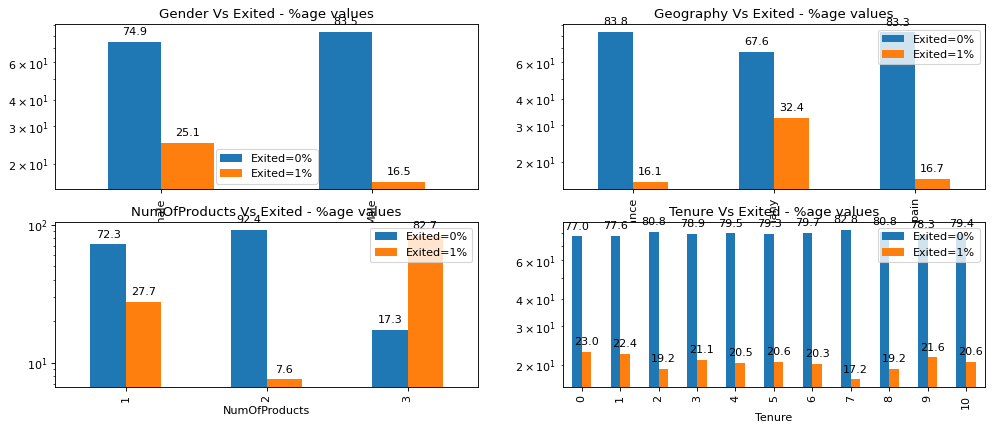

In [473]:
plt.figure(dpi=80, figsize=(30, 15))

plt.subplot(2, 2, 1); plotTargetWiseBarPlots(df, 'Gender', 'Gender')
plt.subplot(2, 2, 2); plotTargetWiseBarPlots(df, 'Geography', 'Geography')
plt.subplot(2, 2, 3); plotTargetWiseBarPlots(df, 'NumOfProducts', 'NumOfProducts')
plt.subplot(2, 2, 4); plotTargetWiseBarPlots(df, 'Tenure', 'Tenure')

Findings:
- Compared to Males, less female customers have exited
- More percentage of the customers from Germany have exited
- Customers with 3 products tend to exit followed by the customers with 1 product. Customers with 2 products tend to be mroe stable.


<AxesSubplot:>

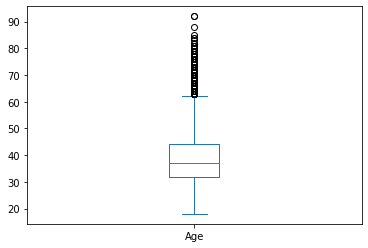

In [474]:
df['Age'].plot.box()

In [475]:
# Add a new column "Age group"
age_group = pd.cut(df.Age,bins=[0,18,30, 40,60,99],labels=['0-18','18-30', '30-40','40-60','60-99'])
df['Age group'] =  age_group
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age group
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,40-60
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,40-60
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,40-60
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,30-40
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,40-60
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0,30-40
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,30-40
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1,30-40
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,40-60


df_1: 2037, df_0: 7963
     Total  Exited=1  Exited=0  Exited=1%  Exited=0%
Age                                                 
18    22.0       2.0        20       9.09      90.91
19    27.0       1.0        26       3.70      96.30
20    40.0       2.0        38       5.00      95.00
21    53.0       3.0        50       5.66      94.34
22    84.0      12.0        72      14.29      85.71
..     ...       ...       ...        ...        ...
83     1.0       0.0         1       0.00     100.00
84     2.0       1.0         1      50.00      50.00
85     1.0       0.0         1       0.00     100.00
88     1.0       0.0         1       0.00     100.00
92     2.0       0.0         2       0.00     100.00

[70 rows x 5 columns]


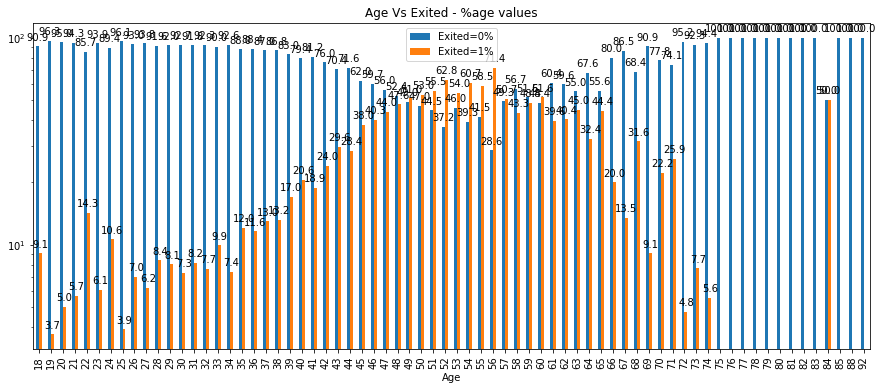

In [476]:
plotTargetWiseBarPlots(df, 'Age', 'Age')

df_1: 2037, df_0: 7963
           Total  Exited=1  Exited=0  Exited=1%  Exited=0%
Age group                                                 
0-18          22         2        20       9.09      90.91
18-30       1946       146      1800       7.50      92.50
30-40       4451       538      3913      12.09      87.91
40-60       3117      1236      1881      39.65      60.35
60-99        464       115       349      24.78      75.22


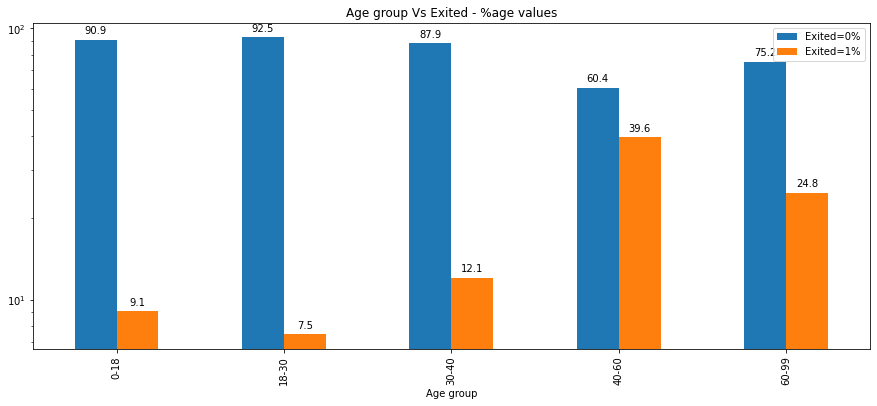

In [477]:
plotTargetWiseBarPlots(df, 'Age group', 'Age group')

Findings:
- Customers in the age group 40 to 60 tend to exit compared to the rest of the age groups

<AxesSubplot:title={'center':'EstimatedSalary'}, xlabel='Exited'>

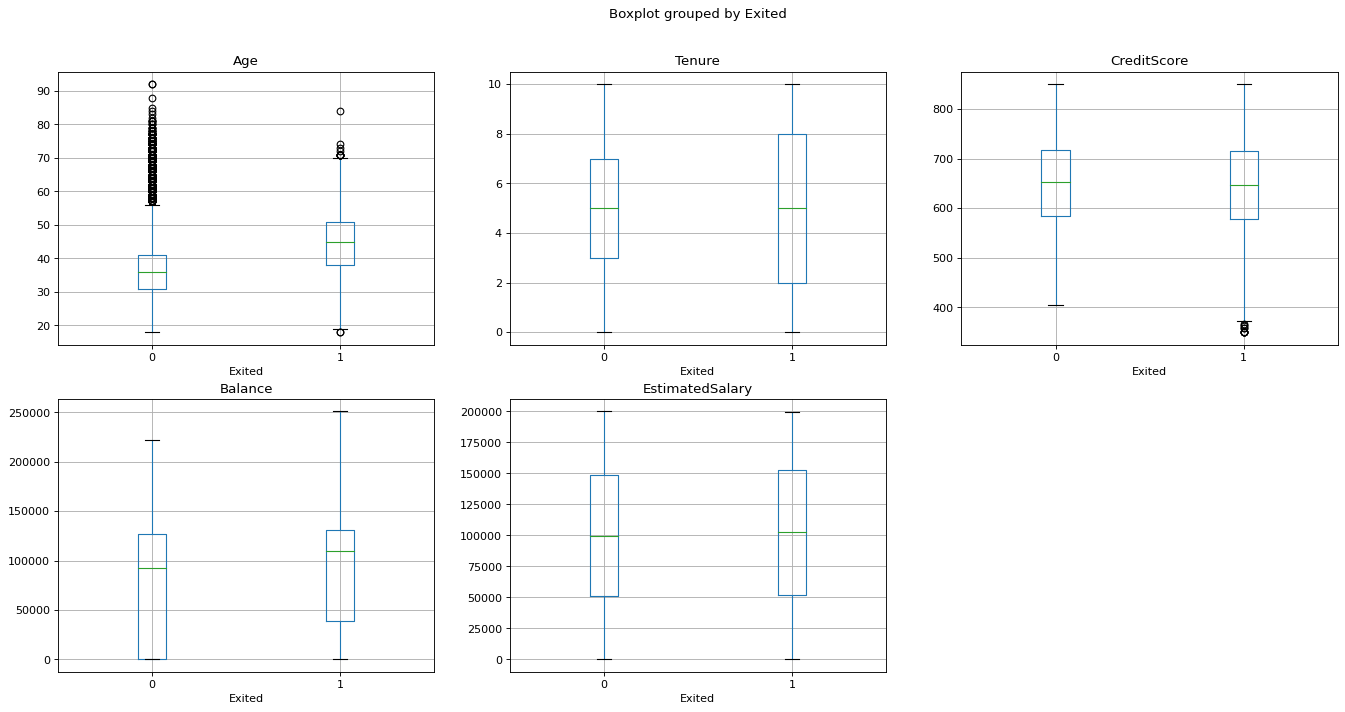

In [478]:
plt.figure(dpi=80, figsize=(20, 10))

ax = plt.subplot(2, 3, 1); df.boxplot('Age', by='Exited', ax=ax)
ax = plt.subplot(2, 3, 2); df.boxplot('Tenure', by='Exited', ax=ax)
ax = plt.subplot(2, 3, 3); df.boxplot('CreditScore', by='Exited', ax=ax)
ax = plt.subplot(2, 3, 4); df.boxplot('Balance', by='Exited', ax=ax)
ax = plt.subplot(2, 3, 5); df.boxplot('EstimatedSalary', by='Exited', ax=ax)

df_1: 2037, df_0: 7963
        Total  Exited=1  Exited=0  Exited=1%  Exited=0%
Tenure                                                 
0         413        95       318      23.00      77.00
1        1035       232       803      22.42      77.58
2        1048       201       847      19.18      80.82
3        1009       213       796      21.11      78.89
4         989       203       786      20.53      79.47
5        1012       209       803      20.65      79.35
6         967       196       771      20.27      79.73
7        1028       177       851      17.22      82.78
8        1025       197       828      19.22      80.78
9         984       213       771      21.65      78.35
10        490       101       389      20.61      79.39


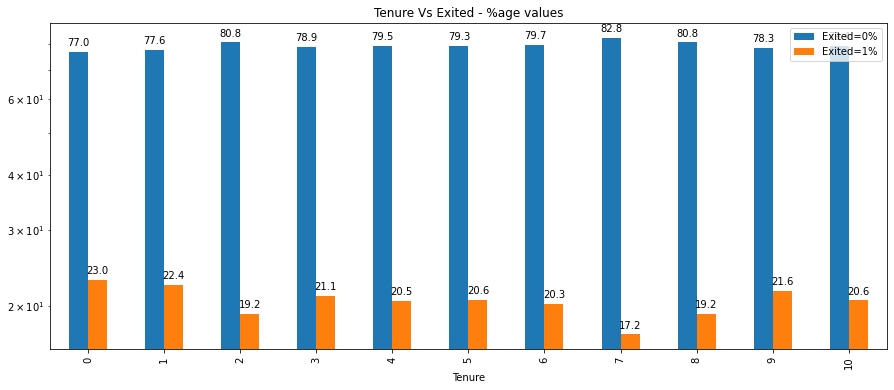

In [479]:
plotTargetWiseBarPlots(df, 'Tenure', 'Tenure')

Findings:
- Customers in the age group 50 to 70 are more likely to exit
- Customers balance in the range 225000 and 250000 tend to exit.
- EstimatedSalary distribution for Exited=0 & Exited=1 is similar

In [480]:
# Reorder the columns
df = df[['Age', 'Gender', 'Geography', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Balance', 'NumOfProducts', 'Tenure', 'CreditScore', 'Exited','Age group']]

# Group the columns for convenience
COLS_NUMERIC = ['Age','EstimatedSalary', 'Balance', 'NumOfProducts', 'Tenure', 'CreditScore'] 
COLS_CATEGORIC = ['Gender', 'Geography', 'HasCrCard', 'IsActiveMember', 'Age group']

In [481]:
# Convert the values of categorical variables to numerical labels/codes
for col in COLS_CATEGORIC:
    df[col] = ConvertClassToNumLabel(df, col)

df.head()

{'Female': 0, 'Male': 1}
{'France': 0, 'Germany': 2, 'Spain': 1}
{0: 1, 1: 0}
{0: 1, 1: 0}
{'0-18': 3, '18-30': 2, '30-40': 1, '40-60': 4, '60-99': 0}


,Age,Gender,Geography,HasCrCard,IsActiveMember,EstimatedSalary,Balance,NumOfProducts,Tenure,CreditScore,Exited,Age group
0,42,0,0,0,0,101348.88,0.00,1,2,619,1,4
1,41,0,1,1,0,112542.58,83807.86,1,1,608,0,4
2,42,0,0,0,1,113931.57,159660.80,3,8,502,1,4
3,39,0,0,1,1,93826.63,0.00,2,1,699,0,1
4,43,0,1,0,0,79084.10,125510.82,1,2,850,0,4


### Create Model

Split to train, validate and test sets

In [482]:
X = df.drop(columns=['Exited'])
y = df['Exited']

In [483]:
X.head()

,Age,Gender,Geography,HasCrCard,IsActiveMember,EstimatedSalary,Balance,NumOfProducts,Tenure,CreditScore,Age group
0,42,0,0,0,0,101348.88,0.00,1,2,619,4
1,41,0,1,1,0,112542.58,83807.86,1,1,608,4
2,42,0,0,0,1,113931.57,159660.80,3,8,502,4
3,39,0,0,1,1,93826.63,0.00,2,1,699,1
4,43,0,1,0,0,79084.10,125510.82,1,2,850,4


In [484]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
print("TRAIN:", y_train.shape[0],"\n", y_train.value_counts(normalize=True)*100, "\n", sep='')
print("TEST:", y_test.shape[0], "\n", y_test.value_counts(normalize=True)*100, "\n",  sep='')

#X_train, X_val, y_train , y_val = train_test_split(X_rest, y_rest, train_size=0.75, random_state=42)
#print("VALIDATION:", y_val.shape[0], "\n", y_val.value_counts(normalize=True)*100, "\n")

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

TRAIN:8000
0    79.45
1    20.55
Name: Exited, dtype: float64

TEST:2000
0    80.35
1    19.65
Name: Exited, dtype: float64

X_train: (8000, 11), X_test: (2000, 11)


### Decision Tree

In [486]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [487]:
evaluate_model(dt, "TRAIN", X_train, y_train);print()
evaluate_model(dt, "TEST", X_test, y_test);print()
print(classification_report(y_test, dt.predict(X_test)))

TRAIN Accuracy : 84.55%
TRAIN Confusion Matrix:
[[6061  295]
 [ 941  703]]

TEST Accuracy : 84.85%
TEST Confusion Matrix:
[[1527   80]
 [ 223  170]]

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1607
           1       0.68      0.43      0.53       393

    accuracy                           0.85      2000
   macro avg       0.78      0.69      0.72      2000
weighted avg       0.83      0.85      0.83      2000



In [493]:
df_fi = pd.DataFrame({
        "variables": X.columns.to_list(),
        "feature importance": dt.feature_importances_})
df_fi.sort_values(by='feature importance', ascending=False).head()

,variables,feature importance
0,Age,0.462755
7,NumOfProducts,0.326011
4,IsActiveMember,0.201143
6,Balance,0.010090
1,Gender,0.000000


Features - Age, Number of products and member activness - are most important.

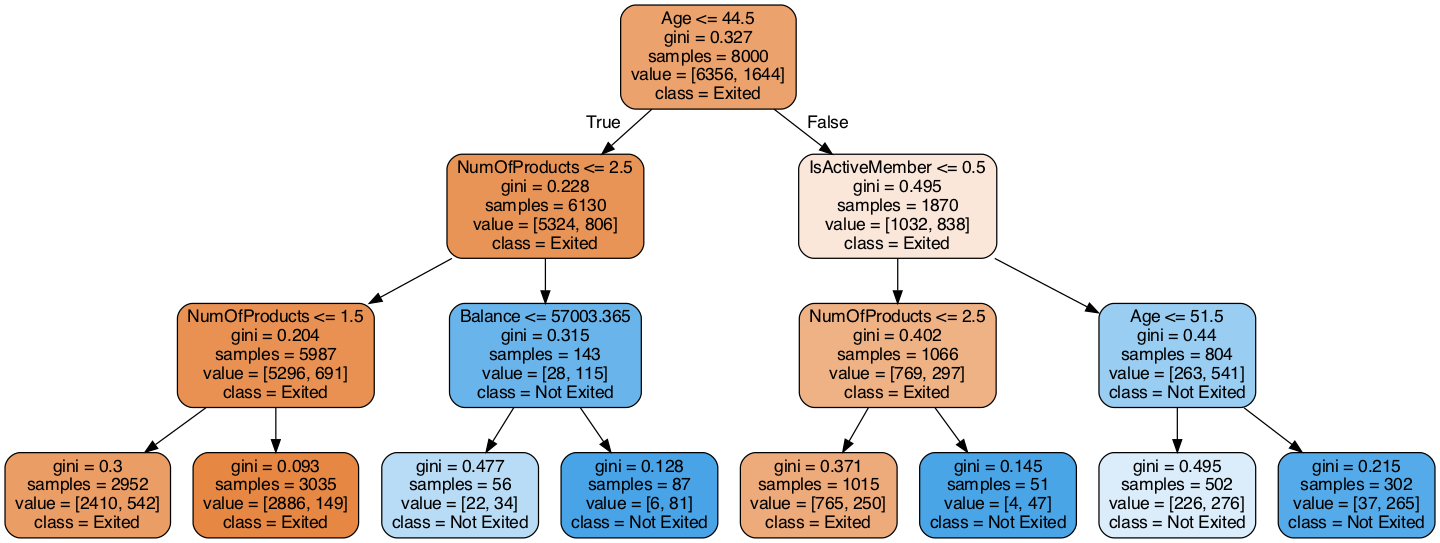

In [488]:
Image(get_dt_graph(dt, X))#, width=1200, height=800)

Interpretation of the model: 

Following Customers tend to exit (churn)
- age <=44.5 years and number of products <=2.5 
- age > 44.5, member is not active and the number of products <=2.5 

Following Customers tend to exit (churn)
- age <=44.5 years and number of products > 2.5 
- age > 44.5, member is not active but number of products > 2.5 
- age > 44.5, member is active


### Decision Tree with hyperparameter tuning

In [ ]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 5],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [ ]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [ ]:
%%time
grid_search.fit(X_train, y_train)

In [ ]:
df_score = pd.DataFrame(grid_search.cv_results_)
df_score.head()

In [ ]:
df_score.nlargest(5,"mean_test_score")

In [ ]:
dt_best = grid_search.best_estimator_
dt_best

In [ ]:
evaluate_model(dt_best, "TRAIN", X_train, y_train);print()
evaluate_model(dt_best, "TEST", X_test, y_test);print()
print(classification_report(y_test, dt_best.predict(X_test)))

In [ ]:
Image(get_dt_graph(dt_best, X))#, width=1200, height=800)

Following Customers tend to exit (churn)
- age <=42.5 years and number of products <=2.5 
- age > 42.5, member is active but number of products <=2.5 
- age > 42.5 and <50.5, member is not active

In [ ]:
evaluate_model(dt, 'Train', X_train, y_train); print()
evaluate_model(dt, 'Validation', X_val, y_val); print()
evaluate_model(dt, 'Test', X_test, y_test); print()